<a id='0'></a>
# 1. Data Load

## Loading needed python packages

In [147]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from datetime import datetime
#Plotting 
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
import seaborn as sns

# Feature Selection
from sklearn.feature_selection import SelectKBest

# ....
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



# Error Metrics
from sklearn.metrics import mean_squared_error


In [148]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Loading the Data

In [149]:
df_1= pd.read_csv("Data/train_identity.csv")
df_2= pd.read_csv("Data/train_transaction.csv")

In [150]:
train_data = df_2.merge(df_1, on="TransactionID", how="left")
train_data.shape

(590540, 434)

## Pre-processed Exploration

In [151]:
train_data.duplicated().sum()

0

In [152]:
train_data["isFraud"].value_counts()



isFraud
0    569877
1     20663
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

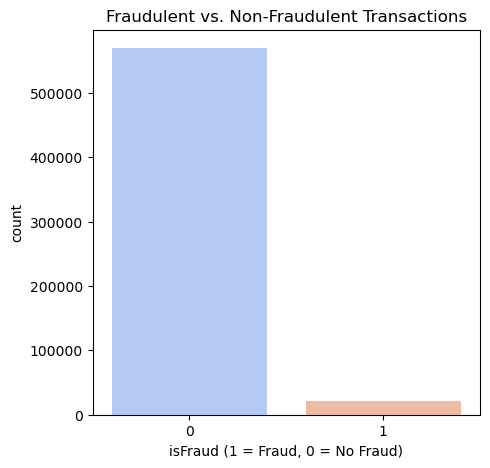

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
sns.countplot(x="isFraud", data=train_data, palette="coolwarm")
plt.title("Fraudulent vs. Non-Fraudulent Transactions")
plt.xlabel("isFraud (1 = Fraud, 0 = No Fraud)")
plt.show

Well, as we can see above, the dataset exhibits a significant imbalance in the target variable `isFraud`, which we are trying to predict. From the earlier exploration:

- The majority class (`isFraud = 0`, non-fraudulent transactions) vastly outnumbers the minority class (`isFraud = 1`, fraudulent transactions).
- This imbalance is evident in the count plot and value counts, where the number of non-fraudulent transactions is much higher than fraudulent ones.

Considere the implications of Imbalance
- **Model Bias**: Machine learning models trained on imbalanced datasets tend to favor the majority class, leading to poor performance in detecting the minority class.
- **Evaluation Metrics**: Accuracy alone is not a reliable metric for imbalanced datasets. Thus, we might need to use metrics like precision, recall, F1-score, and ROC-AUC are more appropriate.
- **Need for Resampling**: Techniques such as oversampling the minority class (ex:SMOTE) or undersampling the majority class can help address the imbalance.

For Next step, in order to mitigate the imbalance, we would need to create balanced subsets of the data by sampling an equal number of instances from both classes. This ensures that the model is trained on a balanced dataset, improving its ability to detect fraudulent transactions. 

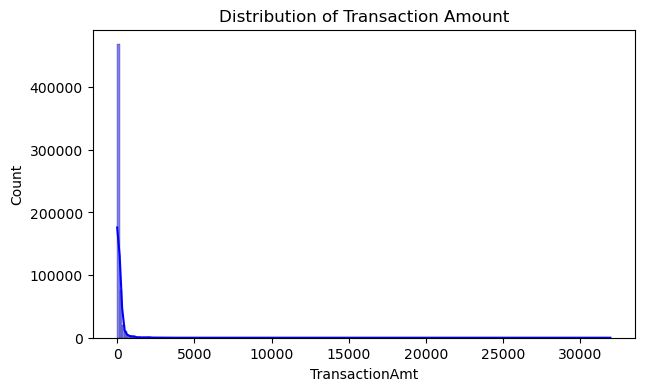

In [154]:
plt.figure(figsize=(7, 4))
sns.histplot(train_data['TransactionAmt'], bins=200, kde=True, color='blue')
plt.title("Distribution of Transaction Amount")
plt.show()

In [155]:
# Check for unique values in categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_cols:
    print(f"{col}: {train_data[col].nunique()} unique values")


Unique Values in Categorical Columns:
ProductCD: 5 unique values
card4: 4 unique values
card6: 4 unique values
P_emaildomain: 59 unique values
R_emaildomain: 60 unique values
M1: 2 unique values
M2: 2 unique values
M3: 2 unique values
M4: 3 unique values
M5: 2 unique values
M6: 2 unique values
M7: 2 unique values
M8: 2 unique values
M9: 2 unique values
id_12: 2 unique values
id_15: 3 unique values
id_16: 2 unique values
id_23: 3 unique values
id_27: 2 unique values
id_28: 2 unique values
id_29: 2 unique values
id_30: 75 unique values
id_31: 130 unique values
id_33: 260 unique values
id_34: 4 unique values
id_35: 2 unique values
id_36: 2 unique values
id_37: 2 unique values
id_38: 2 unique values
DeviceType: 2 unique values
DeviceInfo: 1786 unique values


<a id='1'></a>
# 2. Data Cleaning

### Columns with too much Missing Values

In [156]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * mis_val / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(2)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    

In [157]:
train_missing_value= missing_values_table(train_data)
train_missing_value


Your selected dataframe has 434 columns.
There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.20
id_25,585408,99.13
id_07,585385,99.13
id_08,585385,99.13
id_21,585381,99.13
...,...,...
V285,12,0.00
V284,12,0.00
V280,12,0.00
V279,12,0.00


After checking in the list, we can see the top rows for the % of missing values (more than 70%) include columns about mostly time between previous transactions, the ID columns, and the Vxxx columns which might not be a great idicator. So, we would drop the columns with too much missing value. By now, I chose the threshold of more than 50%.


In [158]:
extreme_null_cols = [col for col in train_data.columns if train_data[col].isna().sum()/train_data.shape[0] > 0.5]
print(len(extreme_null_cols))


214


After checking some columns which could be a great indicator in the extreme_null_cols list, there is no column which is still worth to be kept.

### Columns with low correlation with target variable

In [159]:
# Drop target
features = train_data.drop(columns='isFraud')
# Separate numeric vs categorical
num_cols = features.select_dtypes(include=['number']).columns
cat_cols = features.select_dtypes(include=['object']).columns


In [160]:
from scipy.stats import pointbiserialr

target = train_data['isFraud']
correlations = {}

for col in num_cols:
    try:
        corr, _ = pointbiserialr(train_data[col].fillna(0), target)  # Fill or impute missing
        correlations[col] = abs(corr)
    except:
        correlations[col] = 0

# Sort and view top correlated numerical features
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
sort_corr= pd.DataFrame(sorted_corr, columns=['Feature', 'Abs_Correlation'])


In [161]:
low_corr_cols = list(sort_corr[sort_corr['Abs_Correlation'] < 0.05]['Feature'])

### Columns with many unique value

In [162]:
# Extract columns with more than 70 unique values
high_unique_cols = [col for col in train_data.columns if train_data[col].nunique() > 70]
print(f"Columns with more than 70 unique values: {high_unique_cols}")

Columns with more than 70 unique values: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V95', 'V96', 'V97', 'V99', 'V101', 'V102', 'V103', 'V105', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V143', 'V145', 'V150', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V177', 'V178', 'V179', 'V180', 'V182', 'V187', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V221', 'V222', 'V224', 'V226', 'V229', 'V231', 'V232', 'V233', 'V234', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', '

Fraud detection hinges on identifying subtle behavioral differences in transactions. Key business assumptions:

* Email domains & DeviceInfo: Fraudsters may use uncommon domains/devices.

* Card address mismatches (from M1-M9) often hint at fraud.

* TransactionAmt, D* (timing), and V* features contain engineered behaviors that can differ significantly for fraudulent users.


Based on these business acumens and some quick-check on those high_unique_cols, we will consider drop these columns to ensure the integrity and unecessary noise for the dataset 

### Drop these columns

In [163]:
#Aggregate the columns that we should drop
cols_to_drop = list(set(low_corr_cols+extreme_null_cols+high_unique_cols))
len(cols_to_drop)


338

In [164]:
train_data=train_data.drop(cols_to_drop, axis=1)

In [165]:
train_data

,isFraud,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V48,V49,V50,V51,V52,V53,V57,V58,V59,V60,V63,V64,V69,V70,V71,V72,V73,V74,V75,V77,V78,V79,V80,V81,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V281,V282,V283,V302,V303,V304
0,0,W,discover,credit,NaN,T,T,T,M2,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0,W,visa,debit,outlook.com,T,T,T,M0,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,W,visa,debit,NaN,T,T,T,M0,F,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
590536,0,W,mastercard,debit,gmail.com,T,F,F,M0,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
590537,0,W,mastercard,debit,gmail.com,T,F,F,NaN,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
590538,0,W,mastercard,debit,aol.com,T,T,T,M0,T,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,

<a id='2'></a>
# 3. Post-Cleaned Exploration


## Categorical Columns 

In [166]:
for col in list(train_data.select_dtypes(exclude="number")):
    print(train_data[col].value_counts())
    print("==="*20)

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64
card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: count, dtype: int64
card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: count, dtype: int64
P_emaildomain
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com            

Could do some analysis on here

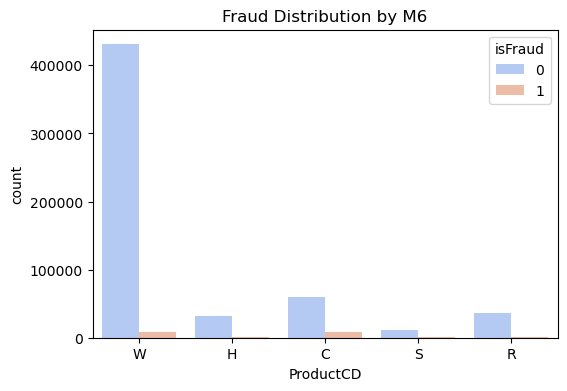

In [167]:
plt.figure(figsize=(6, 4))
sns.countplot(x='ProductCD', hue='isFraud', data=train_data, palette="coolwarm")
plt.title(f"Fraud Distribution by {col}")
plt.show()

In [168]:
cat_cols_train = train_data.select_dtypes(include=['object', 'category']).columns
print(f"Categorical Columns: {list(cat_cols_train)}")


Categorical Columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M6']


In [169]:
for col in cat_cols_train:
    print(f"{col}: {train_data [col].nunique()} unique values")
    print(train_data [col].unique()[:10])  # Show first 10 unique values of each column
    print("-" * 50)

ProductCD: 5 unique values
['W' 'H' 'C' 'S' 'R']
--------------------------------------------------
card4: 4 unique values
['discover' 'mastercard' 'visa' 'american express' nan]
--------------------------------------------------
card6: 4 unique values
['credit' 'debit' nan 'debit or credit' 'charge card']
--------------------------------------------------
P_emaildomain: 59 unique values
[nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com']
--------------------------------------------------
M1: 2 unique values
['T' nan 'F']
--------------------------------------------------
M2: 2 unique values
['T' nan 'F']
--------------------------------------------------
M3: 2 unique values
['T' nan 'F']
--------------------------------------------------
M4: 3 unique values
['M2' 'M0' nan 'M1']
--------------------------------------------------
M6: 2 unique values
['T' 'F' nan]
--------------------------------------------------


<a id='3'></a>
# 4. Feature Engineer

## Business-Related Columns

In [170]:
# ADD new features
#train_data['card1_mean'] = train_data.groupby('card1')['TransactionAmt'].transform('mean')
#train_data['card1_std'] = train_data.groupby('card1')['TransactionAmt'].transform('std')


# Repeat for addr1 (billing address)
#train_data['addr1_mean'] = train_data.groupby('addr1')['TransactionAmt'].transform('mean')
#train_data['addr1_std'] = train_data.groupby('addr1')['TransactionAmt'].transform('std')

# Convert transaction time to hours
#train_data['Transaction_hour'] = (train_data['TransactionDT'] // 3600) % 24


# Flag for night transactions (higher fraud risk)
#train_data['is_night'] = train_data['Transaction_hour'].apply(lambda x: 1 if x < 6 else 0)



# Count number of times a card appears in the dataset
#train_data['card1_count'] = train_data['card1'].map(train_data['card1'].value_counts())


# Define high-risk emails
high_risk_emails = ['mail.com', 'rambler.ru', 'yahoo.com']

train_data['email_risk'] = train_data['P_emaildomain'].apply(lambda x: 1 if x in high_risk_emails else 0)





In [171]:
#train_data['P_emaildomain_enc'] = train_data.groupby('P_emaildomain')['isFraud'].transform('mean')

# Drop original categorical columns
#train_data.drop(['P_emaildomain', 'DeviceInfo'], axis=1, inplace=True)


## OneHotCoder for Categorical Columns

In [172]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply OneHotEncoder to categorical columns
encoded_features = one_hot_encoder.fit_transform(train_data[cat_cols_train])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(cat_cols_train))

# Concatenate the encoded features with the original DataFrame (excluding the original categorical columns)
processed_data = pd.concat([train_data.drop(columns=cat_cols_train), encoded_df], axis=1)

In [173]:
processed_data

,isFraud,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V48,V49,V50,V51,V52,V53,V57,V58,V59,V60,V63,V64,V69,V70,V71,V72,V73,V74,V75,V77,V78,V79,V80,V81,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V281,V282,V283,V302,V303,V304,email_risk,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card4_nan,card6_charge card,card6_credit,card6_debit,card6_debit or credit,card6_nan,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,P_emaildomain_nan,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M6_F,M6_T,M6_nan
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0

<a id='4'></a>
# 5. Model Evaluation

## Train Test Split

In [175]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, classification_report

# Separate features and target
X = processed_data.drop(columns='isFraud')
y = processed_data['isFraud']

# 1. Split original data
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


<a id='4.2'></a>
## Test Options and Evaluation Metrics


In [176]:
# test options for classification
num_folds = 5
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3 Compare Models and Algorithms

### Classification Models

In [ ]:
# spot check the algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#Neural Network
#models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
#models.append(('AB', AdaBoostClassifier()))
#models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
#models.append(('ET', ExtraTreesClassifier()))

### K-folds cross validation

In [180]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.776998 (0.005935)
RF: 0.873297 (0.001915)


### Algorithm comparison

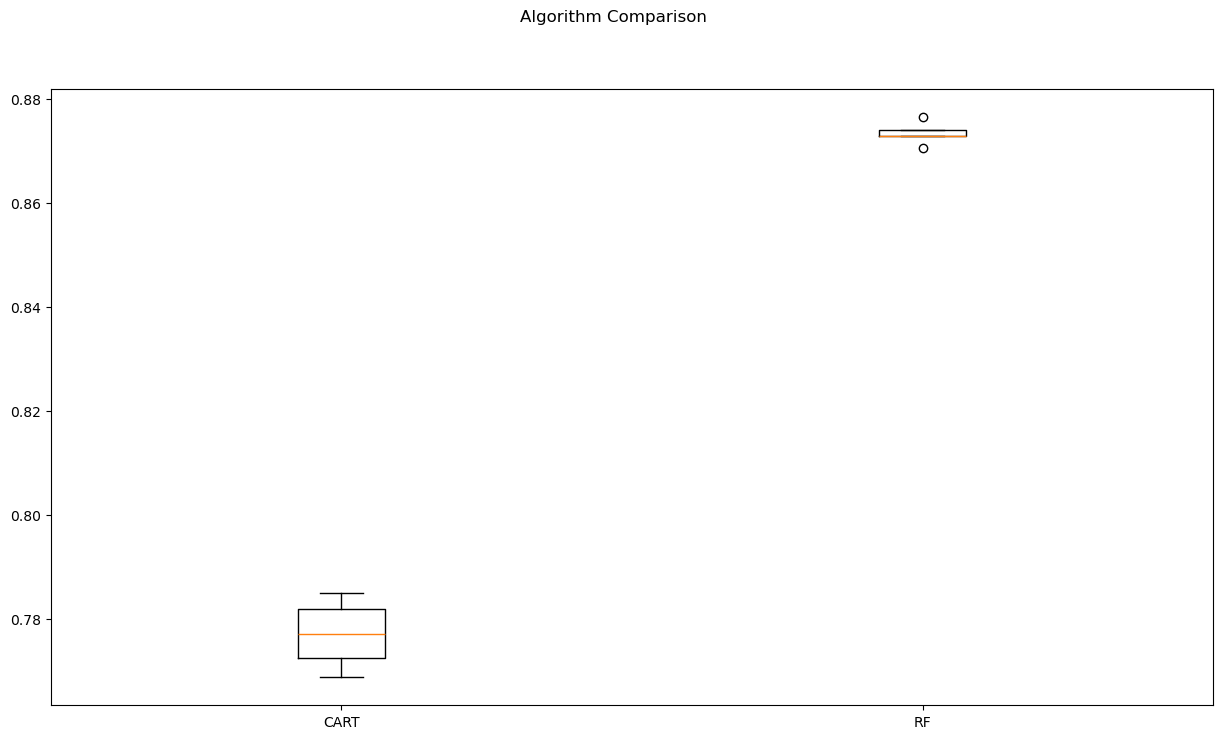

In [181]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Given that the Random Forest is the best model, Grid Search is performed on RF in this step.

In [183]:
# Grid Search: Random Forest
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

KeyboardInterrupt: 

<a id='6'></a>
# 7. Finalise the Model

Looking at the details above Random Forest might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [186]:
# prepare model
model = RandomForestClassifier(max_depth= 5, n_estimators= 180)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [184]:
# estimate accuracy on validation set
predictions = model.predict(X_val)
print(accuracy_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))
print(classification_report(y_val, predictions))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Axes: xlabel='Predicted', ylabel='Actual'>

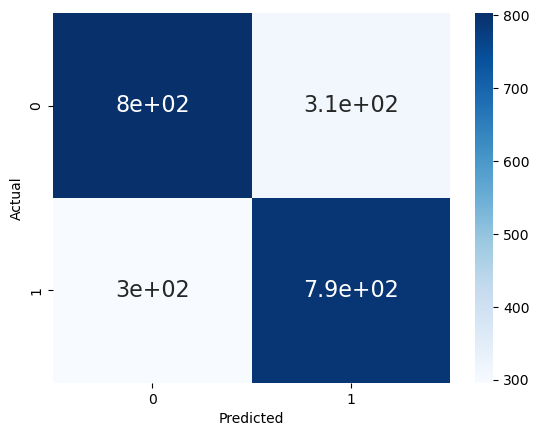

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_val, predictions), columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

[0.00000000e+00 2.25702844e-04 1.20431277e-03 1.05030570e-03
 1.32061381e-03 1.98352795e-04 4.95737245e-04 2.06917557e-04
 9.84768920e-04 1.02337391e-02 4.55103931e-03 2.88030921e-03
 4.63833630e-03 2.34552503e-02 1.23405842e-02 1.42596382e-02
 1.57266749e-02 3.29114021e-03 6.25640430e-03 4.09084291e-02
 3.14358058e-02 9.67637111e-03 1.47452528e-02 2.57610889e-02
 4.19960957e-02 8.47900402e-04 1.32280092e-03 2.69263405e-03
 3.78116659e-03 4.87502276e-03 3.26011329e-03 1.72686006e-03
 1.60898085e-03 1.95055526e-02 2.88190702e-02 1.15750600e-02
 8.27882812e-03 5.71466470e-03 6.74794911e-03 7.70068531e-03
 6.15257432e-03 1.22899039e-02 1.38641919e-02 9.96398035e-04
 5.90028818e-03 3.46193797e-03 3.02708518e-03 3.55767930e-02
 4.74890068e-02 5.88763657e-03 1.46789138e-03 2.22259799e-02
 3.44593743e-02 3.20715096e-03 1.98164668e-03 5.47612301e-03
 1.50142929e-02 1.72965500e-03 9.12531140e-03 8.96635046e-04
 4.98585260e-03 1.67905235e-02 1.49856779e-02 3.09091612e-02
 4.70739851e-02 6.826246

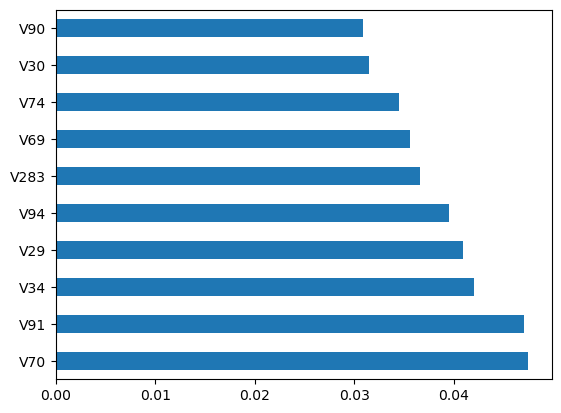

In [ ]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

__Conclusion__:

We showed that data preparation is one of the most important steps. We addressed
that by performing feature elimination by using different techniques such as subjec‐
tive judgement, correlation, visualization and the data quality of the feature.
We illustrated that there can be different ways of handling and analyzing the categorical data and converting categorical data into model usable format.

Finally, we analyzed the feature importance and found that results of the case study
are quite intuitive.

